# Model 1: Multi-scale CNN

In [ ]:
#The original code of a multi-scale CNN can be found at:
#https://github.com/inspire-group/advml-traffic-sign/blob/e090074883cddd92b5cc25a3238dd00f62f15acf/lib/keras_utils.py

In [ ]:
#Check GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#GPU count and name
!nvidia-smi -L

Found GPU at: /device:GPU:0
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-09eb3a05-7ce9-9cdd-cc10-3cdecae7e5ad)


In [ ]:
#mount google drive where dataset is saved
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#Copy gdrive file to local folder. This reduces latency a lot!
!mkdir train_local
!cp /content/gdrive/MyDrive/GTSRB/gtsrb.zip /content/train_local

In [ ]:
#unzip dataset
!unzip -u "/content/train_local/gtsrb.zip" -d "/content/train_local"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train_local/Test/07632.png  
  inflating: /content/train_local/Test/07633.png  
    
 extracting: /content/train_local/Test/GT-final_test.csv  
  inflating: /content/train_local/Test/GT-final_test1.csv  


In [ ]:
#Import libraries and dependencies
!pip install tf-explain
!pip install adversarial-robustness-toolbox

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Concatenate, BatchNormalization, MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import CategoricalAccuracy

#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import time
import pickle

from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import SaliencyMapMethod
from art.attacks.evasion import DeepFool
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.losses import CategoricalCrossentropy

from tf_explain.core.grad_cam import GradCAM

In [ ]:
#Specify the path to training folder and generating the label of training data
train_dir = '/content/train_local/Train/' # Change the path relative to your computer
classes = [str(x) for x in np.linspace(0,43,43).astype(int)]

In [ ]:
#Generate training and validation data with image generator
def image_generator(train_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split = 0.2)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (30,30),
                                  batch_size = 100,
                                  class_mode = 'categorical',
                                  classes = classes,
                                  subset='training')
 
 
    val_generator = train_datagen.flow_from_directory(train_parent_directory,
                                 target_size=(30,30),
                                 batch_size = 25,
                                 class_mode = 'categorical',
                                 classes = classes,
                                 subset='validation')    
  
    
    return train_generator, val_generator

train_generator, val_generator = image_generator(train_dir)

Found 31176 images belonging to 43 classes.
Found 7793 images belonging to 43 classes.


In [ ]:
x_train, y_train = next(train_generator)
x_val, y_val  = next(val_generator)

## Visualize few examples of training data

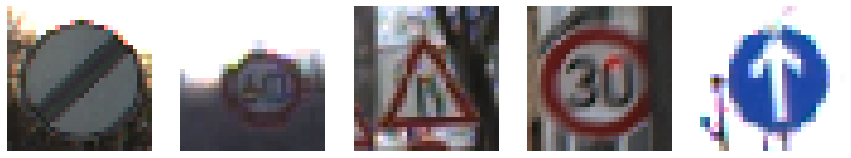

In [ ]:
f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(x_train[j], cmap='binary')
    axs[j].axis('off')

In [ ]:
#Generate Test Data

y_test=pd.read_csv("/content/train_local/Test.csv") #replace with data path in your computer
labels=y_test['Path'].to_numpy()
y_test=y_test['ClassId'].values

data=[]


for f in labels:
    path = '/content/train_local/Test/'+f.replace('Test/', '') #replace with data path in your computer
    img = image.load_img(path, target_size=(30, 30))
    img = image.img_to_array(img)
    data.append(np.array(img))

X_test=np.array(data)
X_test = X_test.astype('float32')/255 

## Model 1: Building the muti-scale CNN

In [ ]:
def build_mltscl():
    """
    Build multiscale CNN. The last layer must be logits instead of softmax.
    Return a compiled Keras model.
    """

    # Regularization
    l2_reg = L2()

    # Build model
    inpt = Input(shape=(30,30,3))
    conv1 = Conv2D(
        32, (5, 5), padding='same', activation='relu')(inpt)
    drop1 = Dropout(rate=0.1)(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(drop1)

    conv2 = Conv2D(
        64, (5, 5), padding='same', activation='relu')(pool1)
    drop2 = Dropout(rate=0.2)(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(drop2)

    conv3 = Conv2D(
        128, (5, 5), padding='same', activation='relu')(pool2)
    drop3 = Dropout(rate=0.3)(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(drop3)

    pool4 = MaxPool2D(pool_size=(4, 4))(pool1)
    pool5 = MaxPool2D(pool_size=(2, 2))(pool2)

    flat1 = Flatten()(pool4)
    flat2 = Flatten()(pool5)
    flat3 = Flatten()(pool3)

    merge = Concatenate(axis=-1)([flat1, flat2, flat3])
    dense1 = Dense(1024, activation='relu',
                                kernel_regularizer=l2_reg)(merge)
    drop4 = Dropout(rate=0.5)(dense1)
    output = Dense(43, activation=None, kernel_regularizer=l2_reg)(drop4)
    model = Model(inputs=inpt, outputs=output)

    # Specify optimizer
    adam = Adam(
        lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss=output_fn, metrics=['accuracy'])

    return model

def output_fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                   logits=predicted)

In [ ]:
model_mtscl = build_mltscl()
model_mtscl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 30, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 30, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 15, 15, 32)   0           dropout[0][0]                    
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history_cnn = model_mtscl.fit(
      train_generator,
      validation_data = val_generator,  
      epochs=10,
      verbose=1)

Epoch 1/10
312/312 [==============================] - 12s 39ms/step - loss: 0.4022 - accuracy: 0.9620 - val_loss: 0.6102 - val_accuracy: 0.9184
Epoch 2/10
312/312 [==============================] - 12s 39ms/step - loss: 0.4057 - accuracy: 0.9629 - val_loss: 0.6201 - val_accuracy: 0.9147
Epoch 3/10
312/312 [==============================] - 12s 39ms/step - loss: 0.3680 - accuracy: 0.9694 - val_loss: 0.6025 - val_accuracy: 0.9118
Epoch 4/10
312/312 [==============================] - 12s 38ms/step - loss: 0.3613 - accuracy: 0.9707 - val_loss: 0.5795 - val_accuracy: 0.9258
Epoch 5/10
312/312 [==============================] - 12s 39ms/step - loss: 0.3585 - accuracy: 0.9706 - val_loss: 0.5627 - val_accuracy: 0.9251
Epoch 6/10
312/312 [==============================] - 12s 39ms/step - loss: 0.3692 - accuracy: 0.9707 - val_loss: 0.6196 - val_accuracy: 0.9061
Epoch 7/10
312/312 [==============================] - 12s 39ms/step - loss: 0.3444 - accuracy: 0.9738 - val_loss: 0.5441 - val_accuracy:

In [ ]:
#Save model
# model_mtscl.save("/content/gdrive/MyDrive/GTSRB/models/model1_6jun7pm")
# model_mtscl.save("/content/gdrive/MyDrive/GTSRB/models/model1_6jun7pm.h5")

#Load model
from tensorflow.keras.models  import load_model
model_mtscl = load_model('/content/gdrive/MyDrive/GTSRB/models/model1_3jun5pm94.01.h5',compile=False)

## Predict model accuracy on clean test images

In [ ]:
# Predict model accuracy on clean test images
pred = np.argmax(model_mtscl.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

0.9399841646872525

## Adversarial Attack

In [ ]:
#Specify Classifier with ART Library
cnn_classifier = TensorFlowV2Classifier(model=model_mtscl, nb_classes=43, input_shape=(30,30,3), loss_object=CategoricalCrossentropy())

In [ ]:
# Take (5) clean images from the test set to be perturbed with different adversarial attacks
x_test_adversarial = X_test
y_test_adversarial = y_test
#print(x_test_adv.shape)

In [ ]:
#Get Model Prediction on Adversarial Images
prediction = model_mtscl.predict(x_test_adversarial)

In [ ]:
probability_pred_clean = np.max(prediction, axis=1)
class_pred_clean = np.argmax(prediction, axis=1)

In [ ]:
#Visualize Clean and Adversarial Images and Distance
def calculateDistance(img1, img2):
    return np.sum((img1-img2)**2)

In [ ]:
#Initialize grad-cam for analysis later
gradcam_explainer = GradCAM()

## Carlini-Wagner

In [ ]:
carlini_attack = CarliniL2Method(classifier = cnn_classifier, targeted=False)

In [ ]:
# Load pickled CW images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 1/x_test_cw_model1.pk", "rb") as input_file:
  x_test_carlini = pickle.load(input_file)

x_test_carlini.shape

(12630, 30, 30, 3)

In [ ]:
#Calculate average L2 distance between clean vs CW images
sum = 0
for i in range(len(x_test_adversarial)):
  sum += calculateDistance(x_test_adversarial[i], x_test_carlini[i])

avgL2_cw = sum / len(x_test_adversarial)
print("Avg L2 distance of generated CW images: ", avgL2_cw)
#Avg L2 distance of generated CW images:  0.7840554016456669

Avg L2 distance of generated CW images:  0.7840554016456669


IndexError: ignored

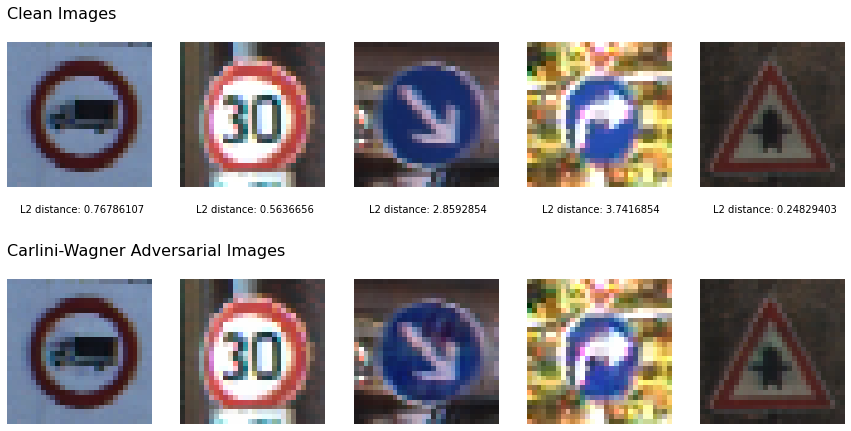

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_carlini)]
title = ['Clean Images', 'Carlini-Wagner Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 35, 'L2 distance: '+ str(distance[i]), ha='center')
    axs[1, i].imshow(x_test_carlini[i], cmap='binary')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

In [ ]:
#Get Model Prediction on Adversarial Images
prediction_cw = model_mtscl.predict(x_test_carlini)

probability_pred_cw = np.max(prediction_cw, axis=1)
class_pred_cw = np.argmax(prediction_cw, axis=1)

IndexError: ignored

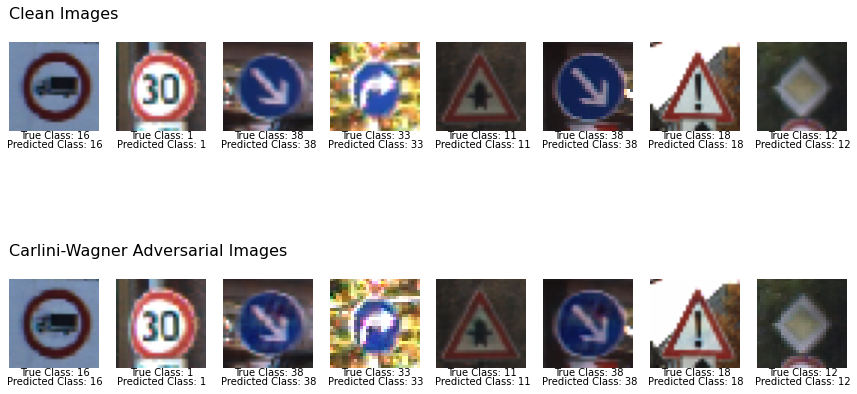

In [54]:
f, axs = plt.subplots(2, 8, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_carlini)]
title = ['Clean Images', 'Carlini-Wagner Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')

    axs[1, i].imshow(x_test_carlini[i], cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_cw[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

IndexError: ignored

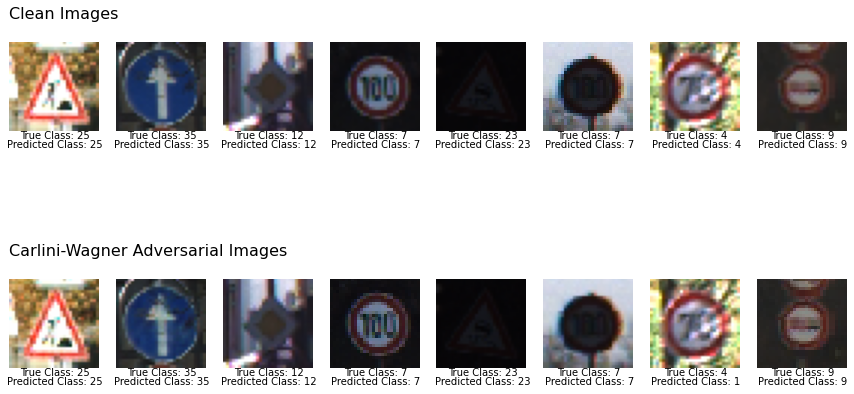

In [57]:
f, axs = plt.subplots(2, 8, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_carlini)]
title = ['Clean Images', 'Carlini-Wagner Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial[8:]):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i+8]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i+8]), ha='center')

    axs[1, i].imshow(x_test_carlini[i+8], cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i+8]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_cw[i+8]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

In [ ]:
# Predict model accuracy on CW images
pred_cw = np.argmax(model_mtscl.predict(x_test_carlini), axis=-1)
accuracy_score(y_test, pred_cw)

0.8201900237529691

In [ ]:
# Predict model accuracy on CW images from model 2
# Load pickled CW images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 2/x_test_cw_model2.pk", "rb") as input_file:
  x_test_carlini_model2 = pickle.load(input_file)

x_test_carlini_model2.shape

# Predict model accuracy
pred_cw_model2 = np.argmax(model_mtscl.predict(x_test_carlini_model2), axis=-1)
accuracy_score(y_test, pred_cw_model2)

0.8746634996041172

In [ ]:
# Predict model accuracy on CW images from model 3
# Load pickled CW images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 3/x_test_cw_model3.pk", "rb") as input_file:
  x_test_carlini_model3 = pickle.load(input_file)

print(x_test_carlini_model3.shape)

# Predict model accuracy
pred_cw_model3 = np.argmax(model_mtscl.predict(x_test_carlini_model3), axis=-1)
accuracy_score(y_test, pred_cw_model3)

(12630, 30, 30, 3)


0.9311163895486936

## Visualize Grad-CAM on Clean and Adversarial CW Images

IndexError: ignored

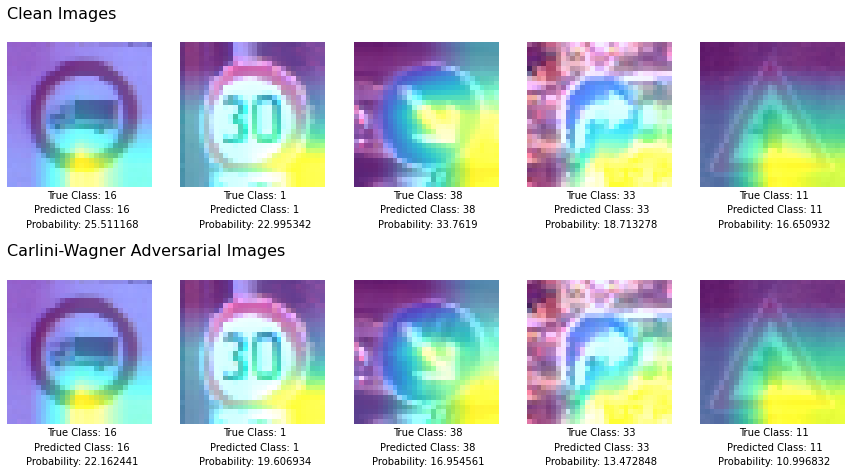

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'Carlini-Wagner Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    data_clean = ([v], None)
    data_adv = ([x_test_carlini[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_cw = gradcam_explainer.explain(data_adv, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, i].imshow(explanation_clean, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, i].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, i].imshow(explanation_cw, cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_cw[i]), ha='center')
    axs[1, i].text(15, 38, 'Probability: '+ str(probability_pred_cw[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

IndexError: ignored

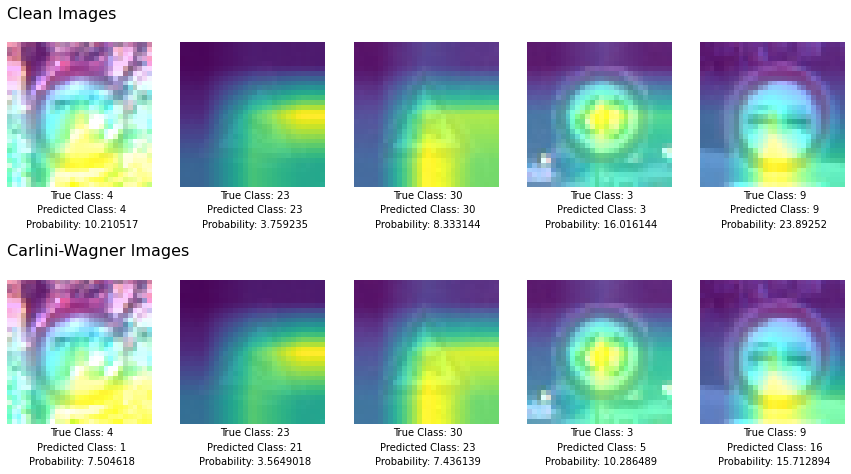

In [ ]:
#Visualize successful attacks

f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'Carlini-Wagner Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
  
a=0
for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_cw[i]):
    data_clean = ([v], None)
    data_adv = ([x_test_carlini[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_cw = gradcam_explainer.explain(data_adv, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, a].imshow(explanation_clean, cmap='binary')
    axs[0, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, a].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, a].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, a].imshow(explanation_cw, cmap='binary')
    axs[1, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, a].text(15, 35, 'Predicted Class: '+ str(class_pred_cw[i]), ha='center')
    axs[1, a].text(15, 38, 'Probability: '+ str(probability_pred_cw[i]), ha='center')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    a += 1
  else:
    i += 1
    v += 1

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

IndexError: ignored

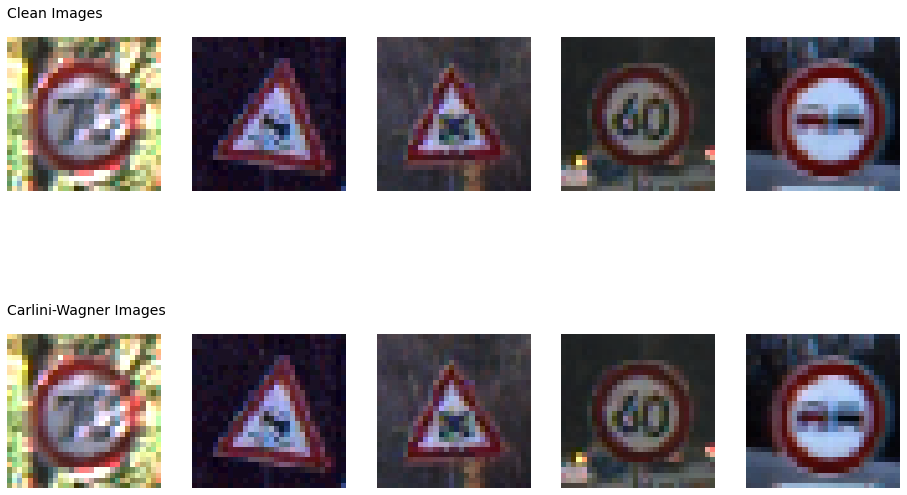

In [ ]:
#Visualize Clean, Perturbed Added, and Adversarial Images on Successfull Attack

f, axs = plt.subplots(2, 5, figsize=(16, 10))
title = ['Clean Images', 'Carlini-Wagner Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=14, pad = 0)
    
a = 0

for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_cw[i]):
    
    #axs[0, a].imshow( ((v/v.max())*255).astype(np.uint8), cmap='binary')
    axs[0, a].imshow( NormalizeData(v), cmap='binary')
    # print("vmin: ", v.min()) 0.0
    # print("vmax: ", v.max()) 6.6313725
    # print("tempImgmin: ", tempImg.min()) -0.12703179
    # print("tempImgmax: ", tempImg.max()) 6.0519924
    #axs[1, a].imshow( NormalizeData(v) - NormalizeData(x_test_carlini[i]) , cmap='binary')
    axs[1, a].imshow( NormalizeData(x_test_carlini[i]), cmap='binary')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    #axs[2, a].axis('off')
    a += 1
  else:
    i += 1
    v += 1

## JSMA

In [ ]:
jsma_attack = SaliencyMapMethod(classifier = cnn_classifier, theta=0.1, gamma=0.01)

In [ ]:
start = time.time()
x_test_jsma = jsma_attack.generate(x = x_test_adversarial)
end = time.time()

print(f"Runtime for generating adv images with JSMA is {end - start} second")

#Save generated images into pickle file
with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_jsma_model1_gamma.01.pk', 'wb') as handle:
    pickle.dump(x_test_jsma, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Runtime for generating adv images with JSMA is 4.637297868728638 second


Runtime for generating adv images with JSMA is 8325.19095158577 second


In [ ]:
#Load pickled JSMA images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 1/x_test_jsma_model1_gamma.01.pk", "rb") as input_file:
  x_test_jsma = pickle.load(input_file)

In [ ]:
# Predict model accuracy on JSMA test images
pred_jsma = np.argmax(model_mtscl.predict(x_test_jsma), axis=-1)
accuracy_score(y_test, pred_jsma)

0.6323832145684877

In [ ]:
#Predict model accuracy on JSMA images for model 2
#Load pickled JSMA images for model 2
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 2/x_test_jsma_model2_gamma.01.pk", "rb") as input_file:
  x_test_jsma_model2 = pickle.load(input_file)

# Predict model accuracy on JSMA test images for model 2
pred_jsma_model2 = np.argmax(model_mtscl.predict(x_test_jsma_model2), axis=-1)
accuracy_score(y_test, pred_jsma_model2)

0.6690419635787807

In [ ]:
#Predict model accuracy on JSMA images for model 3
#Load pickled JSMA images for model 3
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 3/x_test_jsma_model3_gamma.01.pk", "rb") as input_file:
  x_test_jsma_model3 = pickle.load(input_file)

# Predict model accuracy on JSMA test images for model 2
pred_jsma_model3 = np.argmax(model_mtscl.predict(x_test_jsma_model3), axis=-1)
accuracy_score(y_test, pred_jsma_model3)

0.9007125890736342

In [ ]:
#Predict Multi-scale CNN Accuracy on JSMA Images
y_pred_jsma = model_mtscl(x_test_jsma)
y_pred_jsma = np.argmax(y_pred_jsma, axis=1)
acc = sum(1 for x,y in zip(y_pred_jsma, y_test_adversarial) if x == y) / float(len(y_test_adversarial))
acc

TypeError: ignored

In [ ]:
#Calculate average L2 distance between clean vs JSMA images
sum = 0
for i in range(len(x_test_adversarial)):
  sum += calculateDistance(x_test_adversarial[i], x_test_jsma[i])

avgL2_JSMA = sum / len(x_test_adversarial)
print("Avg L2 distance of generated JSMA images: ", avgL2_JSMA)
#Avg L2 distance of generated JSMA images:  0.7610197169266741
#*Avg L2 distance of generated JSMA images:  26.064251680334444

Avg L2 distance of generated JSMA images:  26.064251680334444


## Visualize Clean and JSMA Images and Distance

IndexError: ignored

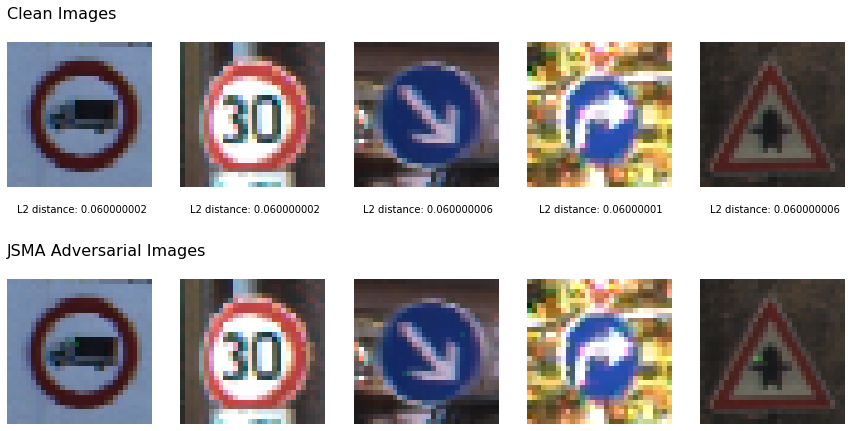

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_jsma)]
title = ['Clean Images', 'JSMA Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 35, 'L2 distance: '+ str(distance[i]), ha='center')
    axs[1, i].imshow(x_test_jsma[i], cmap='binary')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

In [ ]:
#Get Model Prediction on Adversarial Images
prediction_jsma = model_mtscl.predict(x_test_jsma)

probability_pred_jsma = np.max(prediction_jsma, axis=1)
class_pred_jsma = np.argmax(prediction_jsma, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

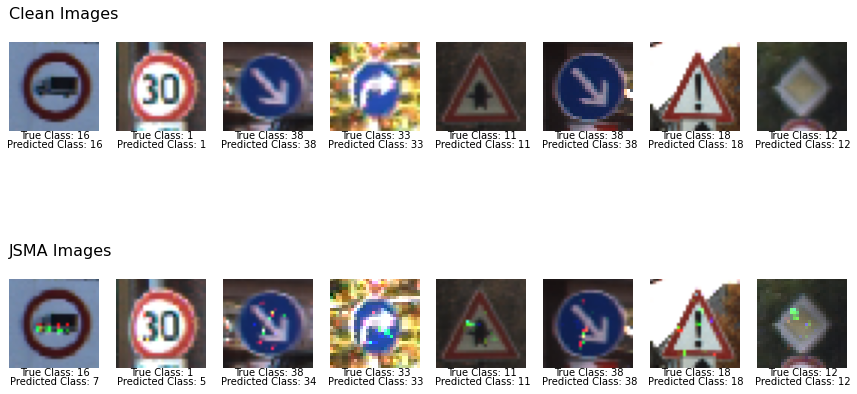

In [ ]:
f, axs = plt.subplots(2, 8, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_carlini)]
title = ['Clean Images', 'JSMA Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[1, i].imshow(x_test_jsma[i], cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_jsma[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

## Visualize Grad-CAM on Clean and JSMA Images

IndexError: ignored

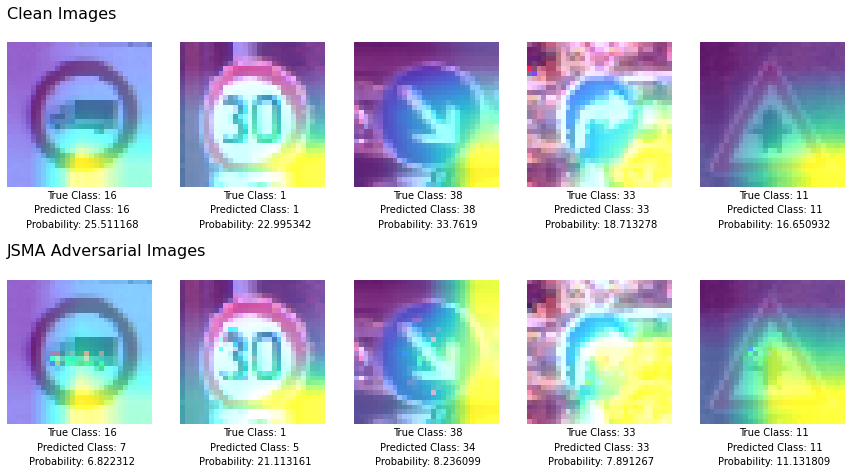

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'JSMA Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    data_clean = ([v], None)
    data_adv = ([x_test_jsma[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_jsma = gradcam_explainer.explain(data_adv, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, i].imshow(explanation_clean, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, i].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, i].imshow(explanation_jsma, cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_jsma[i]), ha='center')
    axs[1, i].text(15, 38, 'Probability: '+ str(probability_pred_jsma[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

IndexError: ignored

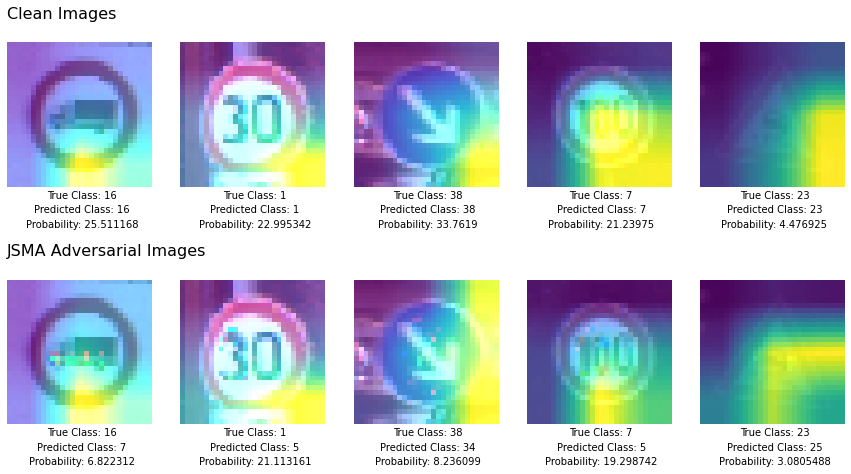

In [ ]:
#Visualize successful attacks

f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'JSMA Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
  
a=0
for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_jsma[i]):
    data_clean = ([v], None)
    data_adv = ([x_test_jsma[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_jsma = gradcam_explainer.explain(data_adv, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, a].imshow(explanation_clean, cmap='binary')
    axs[0, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, a].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, a].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, a].imshow(explanation_jsma, cmap='binary')
    axs[1, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, a].text(15, 35, 'Predicted Class: '+ str(class_pred_jsma[i]), ha='center')
    axs[1, a].text(15, 38, 'Probability: '+ str(probability_pred_jsma[i]), ha='center')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    a += 1
  else:
    i += 1
    v += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
1
2
11
12


IndexError: ignored

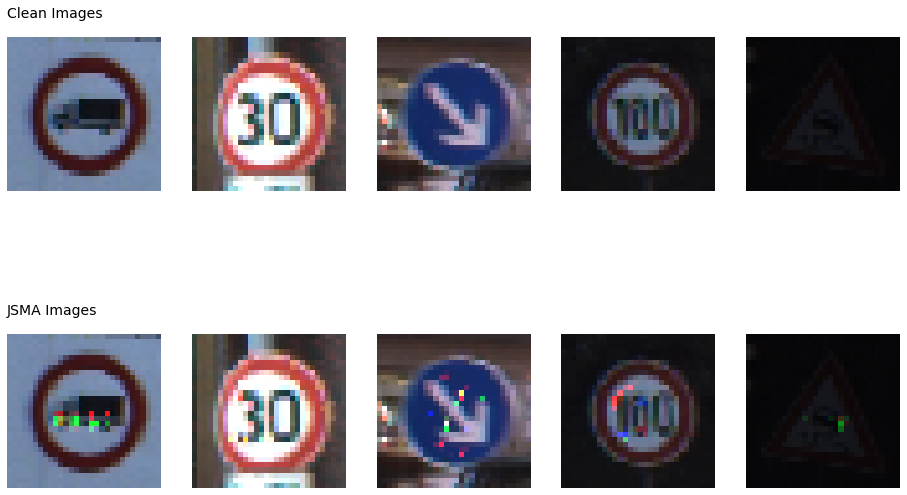

In [ ]:
#Visualize Clean, Perturbed Added, and Adversarial Images on Successfull Attack

f, axs = plt.subplots(2, 5, figsize=(16, 10))
title = ['Clean Images', 'JSMA Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=14, pad = 0)
    
a = 0

for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_jsma[i]):
    
    axs[0, a].imshow(v, cmap='binary')
    axs[1, a].imshow(x_test_jsma[i], cmap='binary')
    #axs[2, a].imshow((x_test_jsma[i]*255).astype(np.uint8), cmap='binary')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    #axs[2, a].axis('off')
    a += 1
    print(i)
  else:
    i += 1
    v += 1

## DeepFool

In [ ]:
df_attack = DeepFool(classifier= cnn_classifier)

In [ ]:
start = time.time()
x_test_df = df_attack.generate(x=x_test_adversarial)
end = time.time()

print(f"Runtime for generating adv images with DeepFool is {end - start} second")

#Save generated images into pickle file
# with open('/content/gdrive/MyDrive/GTSRB/pickles/x_test_df_model1.pk', 'wb') as handle:
#     pickle.dump(x_test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)


Runtime for generating adv images with DeepFool is 74.2985610961914 second


In [ ]:
#Load pickled DeepFool images
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 1/x_test_df_model1.pk", "rb") as input_file:
  x_test_df = pickle.load(input_file)

In [ ]:
# Predict model accuracy on DeepFool test images
pred_df = np.argmax(model_mtscl.predict(x_test_df), axis=-1)
accuracy_score(y_test_adversarial, pred_df)
#82.34% original
#then now 0.7563737133808393

0.8234362628661916

In [ ]:
#Predict model accuracy on DF images for model 2
#Load pickled DF images for model 2
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 2/x_test_df_model2.pk", "rb") as input_file:
  x_test_df_model2 = pickle.load(input_file)

# Predict model accuracy on JSMA test images for model 2
pred_df_model2 = np.argmax(model_mtscl.predict(x_test_df_model2), axis=-1)
accuracy_score(y_test, pred_df_model2)

0.8102137767220903

In [ ]:
#Predict model accuracy on DF images for model 3
#Load pickled DF images for model 3
with open(r"/content/gdrive/MyDrive/GTSRB/pickles/for model 3/x_test_df_model3.pk", "rb") as input_file:
  x_test_df_model3 = pickle.load(input_file)

# Predict model accuracy on JSMA test images for model 2
pred_df_model3 = np.argmax(model_mtscl.predict(x_test_df_model3), axis=-1)
accuracy_score(y_test, pred_df_model3)

0.33285827395091055

In [ ]:
#Calculate average L2 distance between clean vs DeepFool images
sum = 0
for i in range(len(x_test_adversarial)):
  sum += calculateDistance(x_test_adversarial[i], x_test_df[i])

avgL2_df = sum / len(x_test_adversarial)
print("Avg L2 distance of generated DeepFool images: ", avgL2_df)
#0.6617299550568924

Avg L2 distance of generated DeepFool images:  0.6617299550568924


## Visualize Clean and DeepFool Images

In [ ]:
#Get Model Prediction on Adversarial Images
prediction_df = model_mtscl.predict(x_test_df)

probability_pred_df = np.max(prediction_df, axis=1)
class_pred_df = np.argmax(prediction_df, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

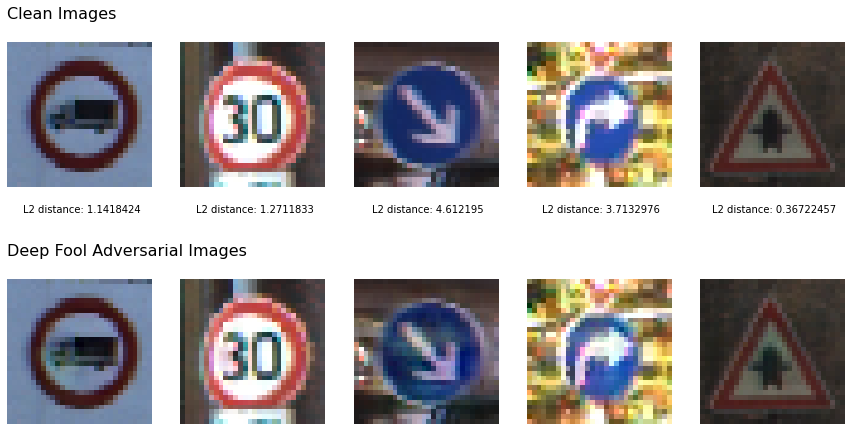

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_df)]
title = ['Clean Images', 'Deep Fool Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 35, 'L2 distance: '+ str(distance[i]), ha='center')
    axs[1, i].imshow(x_test_df[i], cmap='binary')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

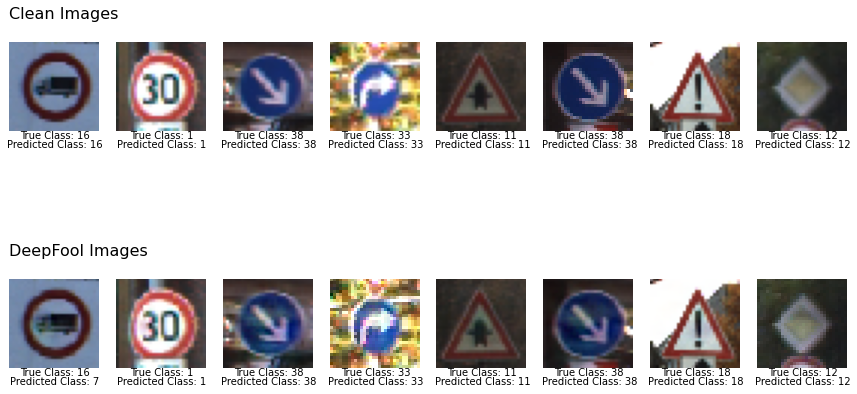

In [ ]:
f, axs = plt.subplots(2, 8, figsize=(15, 8))
#distance = [calculateDistance(x1,x2) for x1,x2 in zip(x_test_adversarial, x_test_carlini)]
title = ['Clean Images', 'DeepFool Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    
    axs[0, i].imshow(v, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[1, i].imshow(x_test_df[i], cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_df[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

## Visualize Grad-CAM on Clean and DeepFool Images

IndexError: ignored

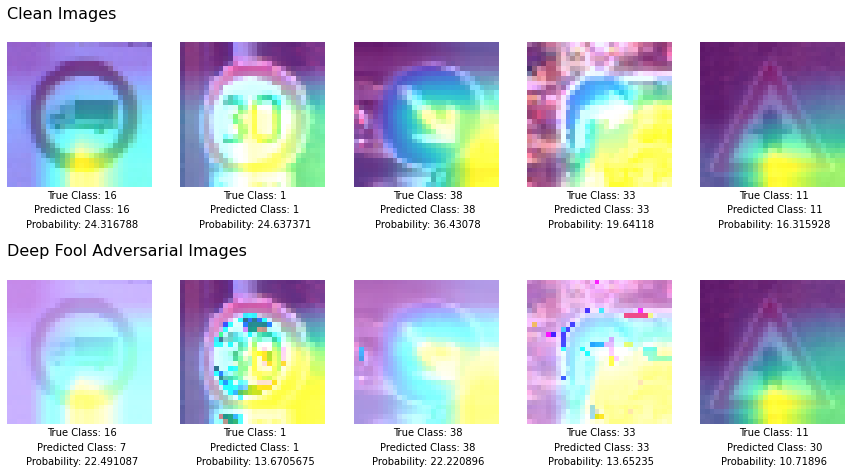

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'Deep Fool Adversarial Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
    
for i,v in enumerate(x_test_adversarial):
    data_clean = ([v], None)
    data_adv = ([x_test_df[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_df = gradcam_explainer.explain(data_adv, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, i].imshow(explanation_clean, cmap='binary')
    axs[0, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, i].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, i].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, i].imshow(explanation_df, cmap='binary')
    axs[1, i].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, i].text(15, 35, 'Predicted Class: '+ str(class_pred_df[i]), ha='center')
    axs[1, i].text(15, 38, 'Probability: '+ str(probability_pred_df[i]), ha='center')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

IndexError: ignored

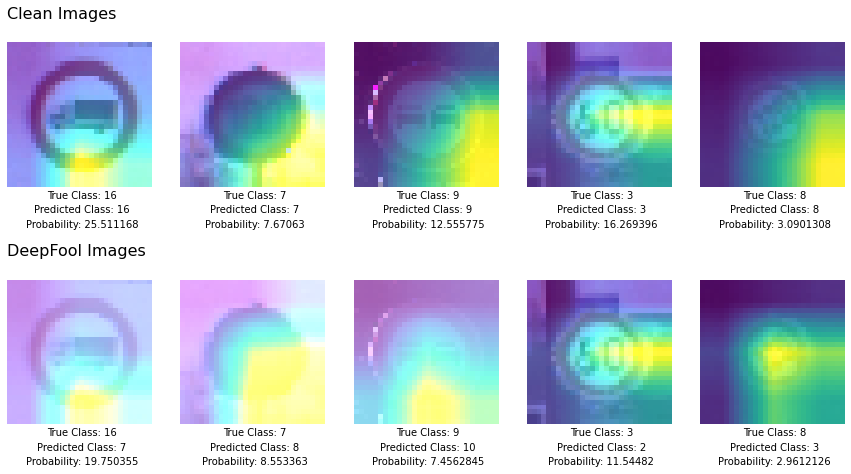

In [ ]:
#Visualize successful attacks

f, axs = plt.subplots(2, 5, figsize=(15, 8))
title = ['Clean Images', 'DeepFool Images']

for row, ax in enumerate(axs, start=0):
    ax[0].set_title("%s \n" % title[row], loc='left', fontsize=16)
  
a=0
for i,v in enumerate(x_test_adversarial):
  if (y_test_adversarial[i] == class_pred_clean[i]) and (y_test_adversarial[i] != class_pred_df[i]):
    data_clean = ([v], None)
    data_adv = ([x_test_df[i]], None)
    explanation_clean = gradcam_explainer.explain(data_clean, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    explanation_df = gradcam_explainer.explain(data_adv, model_mtscl, class_index = y_test_adversarial[i],colormap=cv2.COLORMAP_VIRIDIS)
    
    axs[0, a].imshow(explanation_clean, cmap='binary')
    axs[0, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[0, a].text(15, 35, 'Predicted Class: '+ str(class_pred_clean[i]), ha='center')
    axs[0, a].text(15, 38, 'Probability: '+ str(probability_pred_clean[i]), ha='center')
    axs[1, a].imshow(explanation_df, cmap='binary')
    axs[1, a].text(15, 32, 'True Class: '+ str(y_test_adversarial[i]), ha='center')
    axs[1, a].text(15, 35, 'Predicted Class: '+ str(class_pred_df[i]), ha='center')
    axs[1, a].text(15, 38, 'Probability: '+ str(probability_pred_df[i]), ha='center')
    axs[0, a].axis('off')
    axs[1, a].axis('off')
    a += 1
  else:
    i += 1
    v += 1

# ---------------------------------------